In [91]:
import warnings
warnings.filterwarnings(action='ignore')

import scipy as sp
import scipy.stats
import statsmodels.api as sm
import sklearn as sk
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt
set(sorted([f.name for f in mpl.font_manager.fontManager.ttflist]))
mpl.rc('font', family='NanumGothic')
mpl.rc('axes', unicode_minus=False)

### 6.4 다중공선성과 변수선택

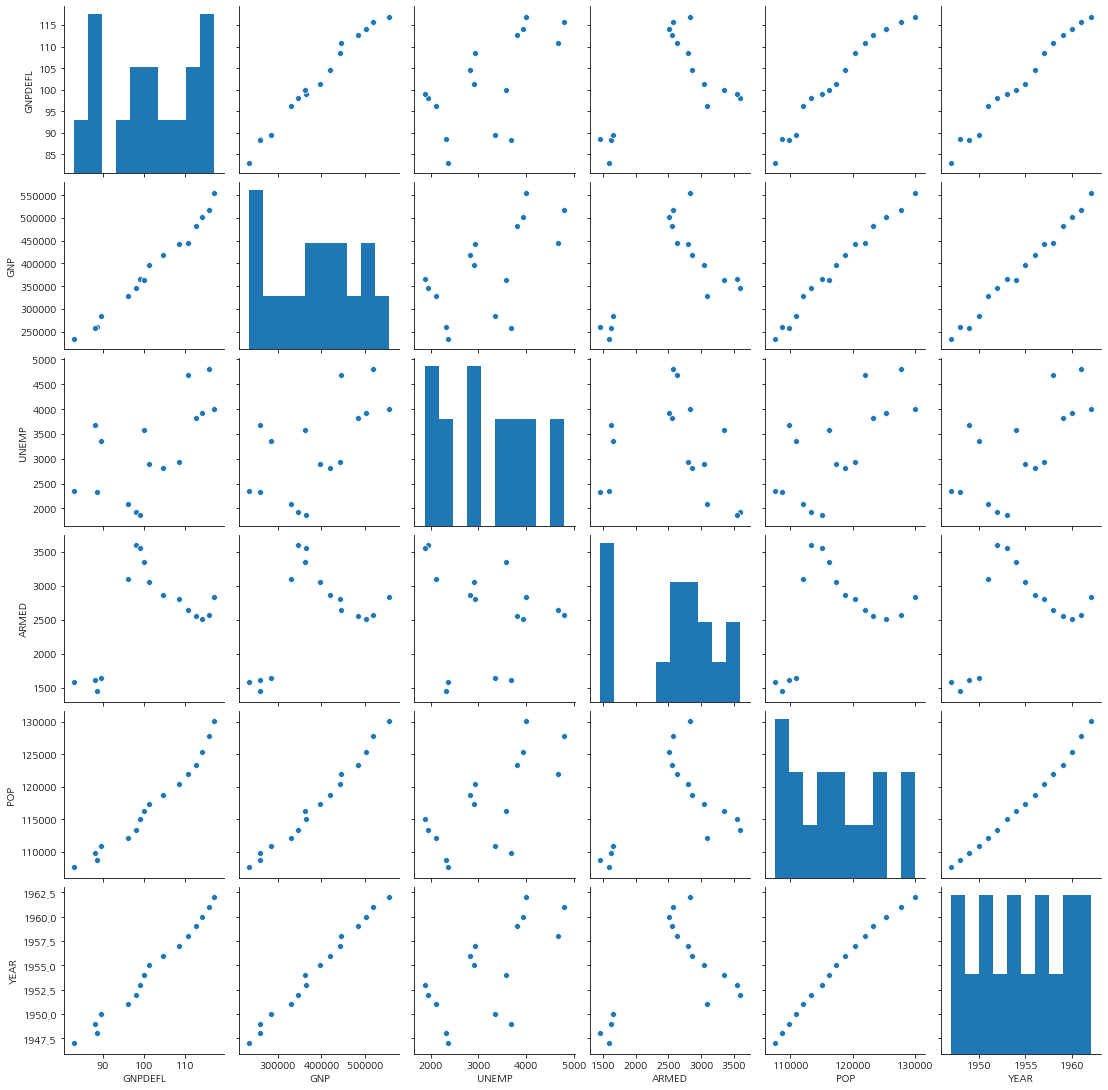

In [7]:
from statsmodels.datasets.longley import load_pandas

dfy = load_pandas().endog
dfX = load_pandas().exog
df = pd.concat([dfy, dfX], axis=1)
sns.pairplot(dfX)
plt.show()

In [9]:
# 상관관계 큼
dfX.corr()

,GNPDEFL,GNP,UNEMP,ARMED,POP,YEAR
GNPDEFL,1.000000,0.991589,0.620633,0.464744,0.979163,0.991149
GNP,0.991589,1.000000,0.604261,0.446437,0.991090,0.995273
UNEMP,0.620633,0.604261,1.000000,-0.177421,0.686552,0.668257
ARMED,0.464744,0.446437,-0.177421,1.000000,0.364416,0.417245
POP,0.979163,0.991090,0.686552,0.364416,1.000000,0.993953
YEAR,0.991149,0.995273,0.668257,0.417245,0.993953,1.000000


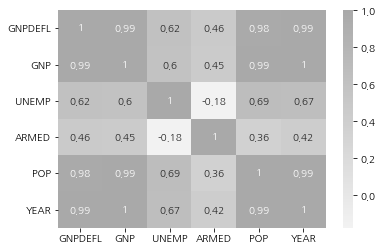

In [10]:
cmap = sns.light_palette("darkgray", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, cmap=cmap)
plt.show()

In [12]:
# 다중공선성 존재하면 조건수 커짐
from sklearn.model_selection import train_test_split

def get_model1(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ GNPDEFL + POP + GNP + YEAR + ARMED + UNEMP", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result1 = get_model1(3)
print(result1.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                     437.5
Date:                Wed, 20 May 2020   Prob (F-statistic):             0.0366
Time:                        11:09:49   Log-Likelihood:                -44.199
No. Observations:                   8   AIC:                             102.4
Df Residuals:                       1   BIC:                             103.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -1.235e+07   2.97e+06     -4.165      0.1

In [14]:
# result에서 R^2값이 1이 나왔었는데
# 테스트데이터로 성능 비교해보니 못미치는 값이 나옴
# 과최적화 발생
def calc_r2(df_test, result):
    target = df.loc[df_test.index].TOTEMP
    predict_test = result.predict(df_test)
    RSS = ((predict_test - target)**2).sum()
    TSS = ((target - target.mean())**2).sum()
    return 1 - RSS / TSS


test1 = []
for i in range(10):
    df_train, df_test, result = get_model1(i)
    test1.append(calc_r2(df_test, result))

test1

[0.9815050656844267,
 0.973849754306501,
 0.9879366370011322,
 0.7588861967876803,
 0.9807206089304095,
 0.8937889315063796,
 0.8798563810571698,
 0.931466577896602,
 0.8608525682213877,
 0.9677198735128874]

### VIF

In [15]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif

,VIF Factor,features
0,12425.514335,GNPDEFL
1,10290.435437,GNP
2,136.224354,UNEMP
3,39.983386,ARMED
4,101193.161993,POP
5,84709.950443,YEAR


In [16]:
# VIF큰 세개를 제외하는 변수 선택을 진행한 후 모형 생성
def get_model2(seed):
    df_train, df_test = train_test_split(df, test_size=0.5, random_state=seed)
    model = sm.OLS.from_formula("TOTEMP ~ scale(GNP) + scale(ARMED) + scale(UNEMP)", data=df_train)
    return df_train, df_test, model.fit()


df_train, df_test, result2 = get_model2(3)
print(result2.summary())

                            OLS Regression Results                            
Dep. Variable:                 TOTEMP   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.981
Method:                 Least Squares   F-statistic:                     118.6
Date:                Wed, 20 May 2020   Prob (F-statistic):           0.000231
Time:                        11:25:23   Log-Likelihood:                -57.695
No. Observations:                   8   AIC:                             123.4
Df Residuals:                       4   BIC:                             123.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     6.538e+04    163.988    398.686   

In [17]:
# 다중공선성을 제거한 후 corss validation
test2 = []
for i in range(10):
    df_train, df_test, result = get_model2(i)
    test2.append(calc_r2(df_test, result))

test2

[0.9763608388904903,
 0.9841984331185691,
 0.9687069366140135,
 0.939730405320177,
 0.9773357061188462,
 0.9561262155732314,
 0.9803852496698645,
 0.9917361722470804,
 0.9837134067639469,
 0.9789512977093211]

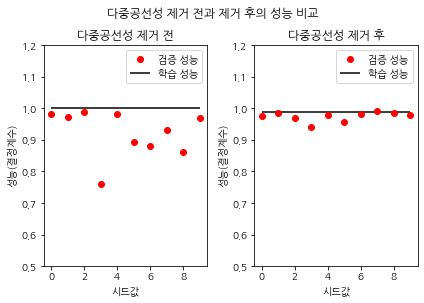

In [18]:
plt.subplot(121)
plt.plot(test1, 'ro', label="검증 성능")
plt.hlines(result1.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 전")
plt.ylim(0.5, 1.2)

plt.subplot(122)
plt.plot(test2, 'ro', label="검증 성능")
plt.hlines(result2.rsquared, 0, 9, label="학습 성능")
plt.legend()
plt.xlabel("시드값")
plt.ylabel("성능(결정계수)")
plt.title("다중공선성 제거 후")
plt.ylim(0.5, 1.2)

plt.suptitle("다중공선성 제거 전과 제거 후의 성능 비교", y=1.04)
plt.tight_layout()
plt.show()

### 보스턴집값 예측문제에 응용

In [19]:
from sklearn.datasets import load_boston
boston = load_boston()

dfX0 = pd.DataFrame(boston.data, columns=boston.feature_names)

from patsy import dmatrix

formula = "scale(CRIM) + scale(I(CRIM ** 2)) + " + \
    "scale(ZN) + scale(I(ZN ** 2)) + scale(INDUS) + " + \
    "scale(NOX) + scale(RM) + scale(AGE) + " + \
    "scale(np.log(DIS)) + scale(RAD) + scale(TAX) + " + \
    "scale(np.log(PTRATIO)) + scale(B) + scale(np.log(LSTAT)) + CHAS"
dfX = dmatrix(formula, dfX0, return_type="dataframe")
dfy = pd.DataFrame(boston.target, columns=["MEDV"])

In [20]:
idx_outlier = \
    np.array([7,  54, 148, 152, 160, 214, 253, 267, 364, 365, 367, 368, 369,
              371, 372, 374, 380, 385, 397, 398, 399, 400, 401, 405, 409, 410,
              412, 413, 414, 415, 416, 418, 419, 426, 445, 489, 490, 492, 505,
              161, 162, 163, 166, 186, 195, 204, 225, 257, 267, 283, 368, 369,
              370, 371, 372])

idx = list(set(range(len(dfX))).difference(idx_outlier))
dfX = dfX.iloc[idx, :].reset_index(drop=True)
dfy = dfy.iloc[idx, :].reset_index(drop=True)

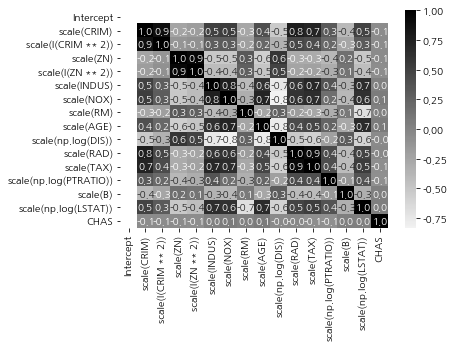

In [21]:
cmap = sns.light_palette("black", as_cmap=True)
sns.heatmap(dfX.corr(), annot=True, fmt='3.1f', cmap=cmap)
plt.show()

In [22]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(
    dfX.values, i) for i in range(dfX.shape[1])]
vif["features"] = dfX.columns
vif = vif.sort_values("VIF Factor").reset_index(drop=True)
vif

,VIF Factor,features
0,1.061624,CHAS
1,1.338325,scale(B)
2,1.478553,Intercept
3,1.780320,scale(np.log(PTRATIO))
4,2.596496,scale(RM)
5,3.748931,scale(AGE)
6,3.807459,scale(INDUS)
7,4.682812,scale(np.log(LSTAT))
8,5.071802,scale(NOX)
9,5.215025,scale(np.log(DIS))


In [23]:
# 변수선택 전
model_boston1 = sm.OLS(np.log(dfy), dfX)
result_boston1 = model_boston1.fit()
print(result_boston1.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.868
Method:                 Least Squares   F-statistic:                     199.9
Date:                Wed, 20 May 2020   Prob (F-statistic):          1.56e-185
Time:                        11:28:29   Log-Likelihood:                 317.45
No. Observations:                 456   AIC:                            -602.9
Df Residuals:                     440   BIC:                            -536.9
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [25]:
# 변수선택 후
cols = ["Intercept", "CHAS", "scale(B)", "scale(CRIM)",
        "scale(np.log(PTRATIO))", "scale(RM)", "scale(np.log(LSTAT))"]

model_boston2 = sm.OLS(np.log(dfy), dfX[cols])
result_boston2 = model_boston2.fit()
print(result_boston2.summary())

                            OLS Regression Results                            
Dep. Variable:                   MEDV   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     380.7
Date:                Wed, 20 May 2020   Prob (F-statistic):          1.42e-172
Time:                        11:29:07   Log-Likelihood:                 260.52
No. Observations:                 456   AIC:                            -507.0
Df Residuals:                     449   BIC:                            -478.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  3

In [26]:
# 변수를 반정도 줄였는데도 결정계수 큰 변화 없음

### 6.5 정규화 선형회귀

In [27]:
def make_nonlinear(seed=0):
    np.random.seed(seed)
    n_samples = 30
    X = np.sort(np.random.rand(n_samples))
    y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.1
    X = X[:, np.newaxis]
    return (X, y)


X, y = make_nonlinear()
dfX = pd.DataFrame(X, columns=["x"])
dfX = sm.add_constant(dfX)
dfy = pd.DataFrame(y, columns=["y"])
df = pd.concat([dfX, dfy], axis=1)

In [28]:
# 정규화 안한
model = sm.OLS.from_formula(
    "y ~ x + I(x**2) + I(x**3) + I(x**4) + I(x**5) + I(x**6) + I(x**7) + I(x**8) + I(x**9)", data=df)
result1 = model.fit()
result1.params

Intercept       -0.169863
x               25.735773
I(x ** 2)     -428.141684
I(x ** 3)     3866.723115
I(x ** 4)   -18340.939667
I(x ** 5)    49326.072553
I(x ** 6)   -78884.743085
I(x ** 7)    74538.645164
I(x ** 8)   -38453.132196
I(x ** 9)     8350.254987
dtype: float64

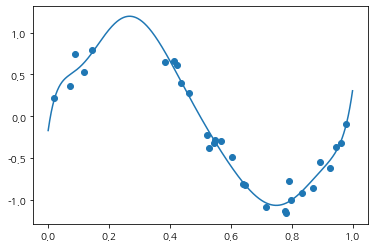

In [29]:
def plot_statsmodels(result):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    dfxx = pd.DataFrame(xx, columns=["x"])
    dfxx = sm.add_constant(dfxx)
    plt.plot(xx, result.predict(dfxx).values)
    plt.show()


plot_statsmodels(result1)

[ 0.63308745 -0.75705866 -1.07056551 -0.76835135 -0.35530367  0.0121939
  0.29917825  0.50969248  0.65793698  0.75851865]


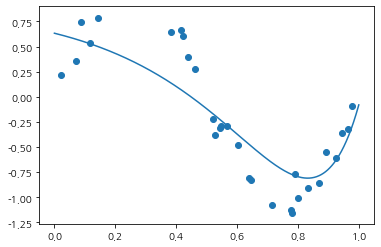

In [30]:
# L1_wt=0 순수 Ridge
result2 = model.fit_regularized(alpha=0.01, L1_wt=0)
print(result2.params)
plot_statsmodels(result2)

Intercept    0.687949
x           -1.129134
I(x ** 2)   -1.124878
I(x ** 3)    0.000000
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.000000
I(x ** 8)    0.281484
I(x ** 9)    1.075281
dtype: float64


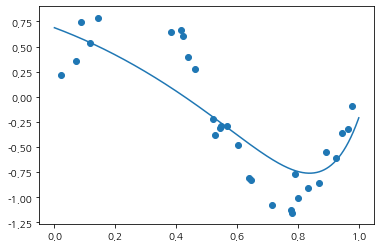

In [31]:
# L1_wt=1 순수Lasso
result3 = model.fit_regularized(alpha=0.01, L1_wt=1)
print(result3.params)
plot_statsmodels(result3)

Intercept    0.656203
x           -0.849745
I(x ** 2)   -1.262902
I(x ** 3)   -0.425687
I(x ** 4)    0.000000
I(x ** 5)    0.000000
I(x ** 6)    0.000000
I(x ** 7)    0.304049
I(x ** 8)    0.631908
I(x ** 9)    0.801206
dtype: float64


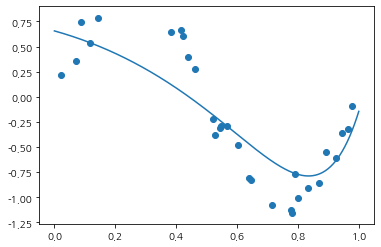

In [33]:
# 0<L1_wt<1 Elastic Net
result4 = model.fit_regularized(alpha=0.01, L1_wt=0.5)
print(result4.params)
plot_statsmodels(result4)

In [ ]:
# regularized하면 차수가 어떻게 되던 결과는 항상 비슷하게
# 즉 안정적인 결과를 줌
# 정규화하면 계수(w)가 너무 크지 않게 나옴
# Ridge의 경우 계수가 작은(음수..?)인 값들 생김
# Lasso의경우 계수 0인애들이 생김
# elastic net은 lasso와 ridge중간이므로 계수가 0도 생기고 작은값들도 생김

### scikit-learn의 정규화 회귀모형

In [34]:
def plot_sklearn(model):
    plt.scatter(X, y)
    xx = np.linspace(0, 1, 1000)
    plt.plot(xx, model.predict(xx[:, np.newaxis]))
    plt.show()

[ 0.00000000e+00  2.57357731e+01 -4.28141683e+02  3.86672311e+03
 -1.83409397e+04  4.93260725e+04 -7.88847431e+04  7.45386451e+04
 -3.84531322e+04  8.35025499e+03]


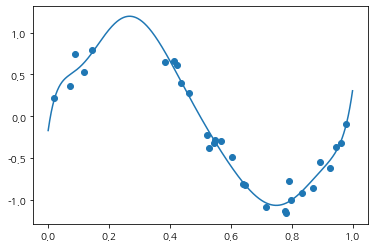

In [35]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

poly = PolynomialFeatures(9)
model = make_pipeline(poly, LinearRegression()).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.          1.51430399 -3.90160797 -2.6359859  -0.41526792  1.07530175
  1.64913273  1.52026782  0.94651401  0.13299614]


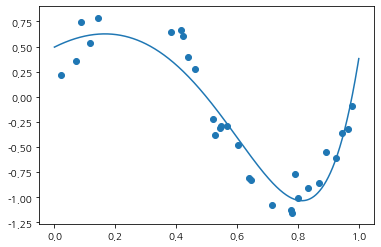

In [36]:
# ridege
model = make_pipeline(poly, Ridge(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.         -0.07668852 -2.44096313 -0.         -0.          0.
  0.          0.          0.          1.88188725]


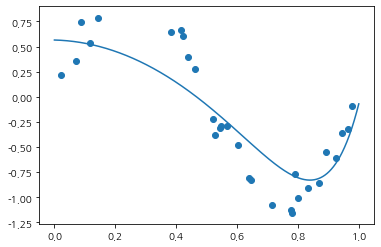

In [37]:
# lasso
model = make_pipeline(poly, Lasso(alpha=0.01)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

[ 0.         -0.83768018 -1.23944649 -0.50166684 -0.          0.
  0.          0.30382246  0.62459231  0.84262899]


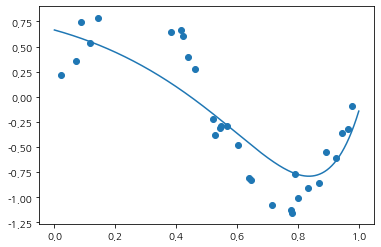

In [38]:
# elasticnet
model = make_pipeline(poly, ElasticNet(alpha=0.01, l1_ratio=0.5)).fit(X, y)
print(model.steps[1][1].coef_)
plot_sklearn(model)

### Ridge 모형과 Lasso 모형의 차이

In [39]:
from sklearn.datasets import load_diabetes
diabetes = load_diabetes()
X = diabetes.data
y = diabetes.target

In [40]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    ridge = Ridge(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([ridge.intercept_, ridge.coef_])))

df_ridge = pd.DataFrame(data, index=alpha).T
df_ridge

,0.001,0.010,0.100,1.000,10.000
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-9.551414,-7.199457,1.307349,29.465746,19.812822
2,-239.090354,-234.552930,-207.194814,-83.154885,-0.918458
3,520.363367,520.583136,489.691080,306.351627,75.416167
4,323.828627,320.523356,301.769437,201.629434,55.025419
5,-712.328205,-380.607066,-83.466074,5.909369,19.924600
6,413.383794,150.483752,-70.828096,-29.515927,13.948686
7,65.811629,-78.591232,-188.680164,-152.040465,-47.553816
8,167.513774,130.313059,115.712703,117.311715,48.259420
9,720.944468,592.349587,443.814054,262.944995,70.144068


In [41]:
alpha = np.logspace(-3, 1, 5)

data = []
for i, a in enumerate(alpha):
    lasso = Lasso(alpha=a).fit(X, y)
    data.append(pd.Series(np.hstack([lasso.intercept_, lasso.coef_])))

df_lasso = pd.DataFrame(data, index=alpha).T
df_lasso

,0.001,0.010,0.100,1.000,10.000
0,152.133484,152.133484,152.133484,152.133484,152.133484
1,-8.998449,-1.306575,-0.000000,0.000000,0.000000
2,-238.899740,-228.822331,-155.362882,-0.000000,0.000000
3,520.261362,525.560658,517.182017,367.701852,0.000000
4,323.429484,316.175320,275.082351,6.301904,0.000000
5,-720.251734,-307.013677,-52.540269,0.000000,0.000000
6,421.405141,89.321688,-0.000000,0.000000,0.000000
7,66.734168,-105.081398,-210.159753,-0.000000,-0.000000
8,164.448873,119.597989,0.000000,0.000000,0.000000
9,725.340440,571.330871,483.914409,307.605700,0.000000


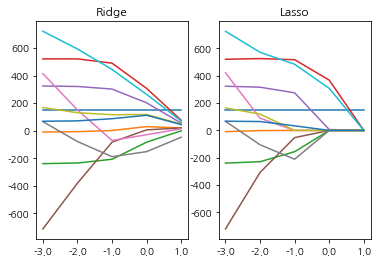

In [42]:
ax1 = plt.subplot(121)
plt.semilogx(df_ridge.T)
plt.xticks(alpha, labels=np.log10(alpha))
plt.title("Ridge")

ax2 = plt.subplot(122)
plt.semilogx(df_lasso.T)
plt.xticks(alpha, labels=np.log10(alpha))
plt.title("Lasso")

plt.show()

### 최적정규화
```
학습용 데이터를 사용한 성능은 정규화 가중치  α 가 작으면 작을 수록 좋아진다.(과최적화)
검증용 데이터를 사용한 성능은 정규화 가중치  α 가 특정한 범위에 있을 때 가장 좋아진다.
```

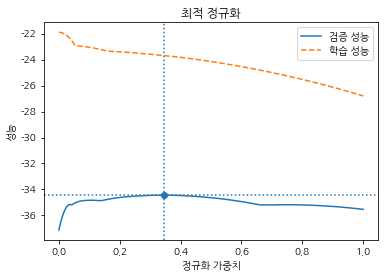

In [43]:
from sklearn.datasets import load_boston
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

boston = load_boston()
X = boston.data
y = boston.target

alphas = np.logspace(-4, 0, 200)

train_scores = []
test_scores = []
for alpha in alphas:
    model = Lasso(alpha=alpha)
    train_score = -mean_squared_error(y, model.fit(X, y).predict(X))
    test_score = np.mean(cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
    train_scores.append(train_score)
    test_scores.append(test_score)

optimal_alpha = alphas[np.argmax(test_scores)]
optimal_score = np.max(test_scores)

plt.plot(alphas, test_scores, "-", label="검증 성능")
plt.plot(alphas, train_scores, "--", label="학습 성능")
plt.axhline(optimal_score, linestyle=':')
plt.axvline(optimal_alpha, linestyle=':')
plt.scatter(optimal_alpha, optimal_score)
plt.title("최적 정규화")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.show()

### 검증성능 곡선

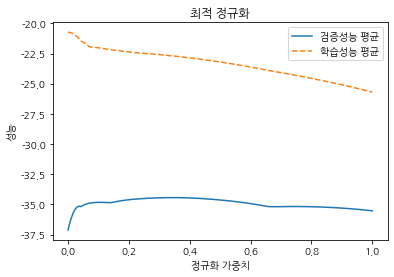

In [45]:
from sklearn.model_selection import validation_curve

train_scores, test_scores = validation_curve(
    Lasso(), X, y, "alpha", alphas, cv=5,
    scoring="neg_mean_squared_error")
# cv=5 5번 반복하여 평균낸것
plt.plot(alphas, test_scores.mean(axis=1), "-", label="검증성능 평균")
plt.plot(alphas, train_scores.mean(axis=1), "--", label="학습성능 평균")
plt.ylabel('성능')
plt.xlabel('정규화 가중치')
plt.legend()
plt.title("최적 정규화")
plt.show()

### 다항회귀의 차수결정
```
다항회귀에서 차수가 감소하면 모형의 제약조건이 더 강화되므로 정규화 가중치가 커지는 것과 같다. 반대로 차수가 증가하면 모형의 제약조건이 감소하므로 정규화 가중치가 작아지는 것과 같다. 따라서 다항회귀에서 최적의 차수를 결정하는 문제는 최적 정규화에 해당한다.
```

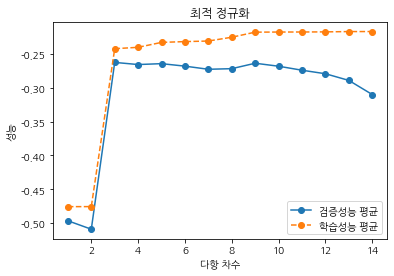

In [47]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

n_samples = 100
np.random.seed(0)
X = np.sort(np.random.rand(n_samples))
y = np.sin(2 * np.pi * X) + np.random.randn(n_samples) * 0.5
X = X[:, np.newaxis]


model = Pipeline([("poly", PolynomialFeatures()),
                  ("lreg", LinearRegression())])

degrees = np.arange(1, 15)
train_scores, test_scores = validation_curve(
    model, X, y, "poly__degree", degrees, cv=100,
    scoring="neg_mean_squared_error")

plt.plot(degrees, test_scores.mean(axis=1), "o-", label="검증성능 평균")
plt.plot(degrees, train_scores.mean(axis=1), "o--", label="학습성능 평균")
plt.ylabel('성능')
plt.xlabel('다항 차수')
plt.legend()
plt.title("최적 정규화")
plt.show()

### NLTK 자연어 처리 패키지

말뭉치(Corpus)
텍스트 분석에 필요한 텍스트 데이터
- 웹크롤링 등으로 수집
- 텍스트 처리 패키지에서 제공하는 샘플 Corpus

#### step1: 샘플 말뭉치 다운로드

In [ ]:
import nltk

In [54]:
%%time
nltk.download("book")
nltk.download("movie_reviews")
nltk.download("punkt")
nltk.download("stopwords")

Wall time: 13.1 ms


[nltk_data] Downloading collection 'book'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     C:\Users\shs40\AppData\Roaming\nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     C:\Users\shs40\AppData\Roaming\nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package chat80 to
[nltk_data]    |     C:\Users\shs40\AppData\Roaming\nltk_data...
[nltk_data]    |   Package chat80 is already up-to-date!
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\shs40\AppData\Roaming\nltk_data...
[nltk_data]    |   Package cmudict is already up-to-date!
[nltk_data]    | Downloading package conll2000 to
[nltk_data]    |     C:\Users\shs40\AppData\Roaming\nltk_data...
[nltk_data]    |   Package conll2000 is already up-to-date!
[nltk_data]    | Downloading package conll2002 to
[nltk_data]    |     C:\Users\shs40\AppData\R

True

#### step2: 구텐베르그 말뭉치 목록

In [53]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

#### step 3: "제인 오스틴"의 "엠마" 말뭉치

In [56]:
# emma소설의 702줄만 가져와봄
emma_raw = nltk.corpus.gutenberg.raw("austen-emma.txt")
print(emma_raw[:702])

[Emma by Jane Austen 1816]

VOLUME I

CHAPTER I


Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence; and had lived nearly twenty-one years in the world
with very little to distress or vex her.

She was the youngest of the two daughters of a most affectionate,
indulgent father; and had, in consequence of her sister's marriage,
been mistress of his house from a very early period.  Her mother
had died too long ago for her to have more than an indistinct
remembrance of her caresses; and her place had been supplied
by an excellent woman as governess, who had fallen little short
of a mother in affection.


### 토큰화
```
말뭉치(텍스트 데이터)를 "토큰"이라고 불리는 작은 단위로 나누는 행위
(문장이 토큰일수도 있고 단어가 토큰일수도 있음, 필요에 따라 달라짐)

토큰: 문장, 단어, 형태소등 분석에 있어서 의미를 가지는 단위

-영어: 의미가 같은 '정규화된 단어'
    I am a boy. => I + am + a + boy + .

-한국어: 의미가 같은 '정규화된 형태소'
    나는 소년이다. => 나 + 는 + 소년 + 이 + 다 + .
```

### 정규화
```
 의미와 쓰임이 같은 단어를 같은 토큰으로 표시
 am Am is are (의미는 같음 문법때문에 다르게 표기된것)
 ->같은 토큰으로 사용해야함
 fly flies flew -> 과거나 3인칭 단수로인해 형태만 다르고 같은 의미 
 ->같은토큰 사용해야함
 
- 대소문자 통합 (case removal)
- 어간 추출 (stemming)
- 표제어 추출 (lemmaization)
- 품사 부착 (Part-Of-Speech tagging)
- 불용어 (stopwords)
```

### 어간 추출
어간추출( stemming)
- 단어를 어간과 접사로 분리하여 단순히 접사를 삭제하거나 교체
    - 어간(stem): 단어의 의미를 담고 있는 핵심 부분
    - 접사(affix): 단어에 부가적인 의미를 주는 부분
        
- 단순알고리즘 사용: 단순히 어미를 끊어 내는 알고리즘..
    - 포터(porter)알고리즘
    - 렝케스터(Lancaster)알고리즘

### 표제어 추출
- 표제어 추출(Lemmatization)
        - 기본 사전형 단어로 변형
        - am, is, are, was, were, been =>be
        - has, had => have
        - 사전정보(WordNet)사용

### 품사 부착
- 품사(POS:Part-Of-Speech)
    -단어의 쓰임에 따른 구분
- 동일한 철자의 단어가 다른의미나 다른 품사로 쓰이는 경우
    - 다른 토큰으로 토큰화
    
- 예
    - permit: 허락하다(동사), 허가증(명사)
    - Refuse: 거부하다(동사), 쓰레기/배출(명사)

### 불용어
- 불용어(Stop-Words)
    - 분석의 필요가 없는 단어
    - 모든 문서에 너무 자주 쓰이는 단어
    - 너무 드물게나타나는 단어
    - 예: a , 은, 는

### 실습 2: 토큰화와 정규화

#### step1: 토큰화
- NLTK의 word_tokenize함수 사용

In [61]:
# 50~196번째 글자 추출
sent= emma_raw[50:196]
print(sent)

Emma Woodhouse, handsome, clever, and rich, with a comfortable home
and happy disposition, seemed to unite some of the best blessings
of existence


In [64]:
from nltk.tokenize import word_tokenize
word_tokenize(sent)

['Emma',
 'Woodhouse',
 ',',
 'handsome',
 ',',
 'clever',
 ',',
 'and',
 'rich',
 ',',
 'with',
 'a',
 'comfortable',
 'home',
 'and',
 'happy',
 'disposition',
 ',',
 'seemed',
 'to',
 'unite',
 'some',
 'of',
 'the',
 'best',
 'blessings',
 'of',
 'existence']

In [65]:
from nltk.stem import PorterStemmer, LancasterStemmer

In [69]:
# stemmer -> 표제어를 찾기위한 원시적인 시도(기본 사전형 단어)
st1=PorterStemmer()
st2=LancasterStemmer()
words=["fly","flies","flying","flew","flown"]
print("Porter Stemmer : ",[st1.stem(w)for w in words])
print("Lancaster Stemmer : ",[st2.stem(w)for w in words])
# porter Lancaster의 한계: flew flown을 분류하지 못함 원래는 바뀌어야 함

Porter Stemmer :  ['fli', 'fli', 'fli', 'flew', 'flown']
Lancaster Stemmer :  ['fly', 'fli', 'fly', 'flew', 'flown']


### step3: 표제어 추출
- NLTK의  WordNetLemmatizer사용

In [75]:
# WordNet -> 인터넷 사전 
# 사전을 사용하여 표제어를 찾아줌
# fly -> 동사면 날다 명사면 파리
# pos라는 걸로 동사(v)임을 지정
# 오래걸림
from nltk.stem import WordNetLemmatizer
lm=WordNetLemmatizer()
[lm.lemmatize(w,pos='v')for w in words]

['fly', 'fly', 'fly', 'fly', 'fly']

- NLTK의 pos_tag사용

In [80]:
from nltk.tag import pos_tag
# refuse permit이 두번쓰이는데 한번은 명사 한번은 동사로 쓰임
sentence="Emma refused to permit us to obtain the refuse permit"
# word_tokenize로 끊고 각각의 단어에 대해 pos_tag를 하면 품사이름이 붙음
# 품사를 tag라고..?
# refuse permit을 명사와 동사로 구분해냄
# 결과가 튜플의 리스트로 나옴
tagged_list=pos_tag(word_tokenize(sentence))
tagged_list

[('Emma', 'NNP'),
 ('refused', 'VBD'),
 ('to', 'TO'),
 ('permit', 'VB'),
 ('us', 'PRP'),
 ('to', 'TO'),
 ('obtain', 'VB'),
 ('the', 'DT'),
 ('refuse', 'NN'),
 ('permit', 'NN')]

In [83]:
# /뒤에 tag가 붙는 형태 많이 쓰여 이 함수 알아 두면 좋음
def tokenizer(doc):
    tagged_list= pos_tag(word_tokenize(doc))
    return ["/".join(p)for p in tagged_list]
tokenizer(sentence)

['Emma/NNP',
 'refused/VBD',
 'to/TO',
 'permit/VB',
 'us/PRP',
 'to/TO',
 'obtain/VB',
 'the/DT',
 'refuse/NN',
 'permit/NN']

In [134]:
from nltk.corpus import stopwords
stopwords.words("english")[:20]
# 영어의 불용어목록 중 20개만 뽑아봄

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his']

### NLTK의 빈도 분석
- 두가지 클래스 사용
     - Text 클래스
     - FreqDIst 클래스

#### Text클래스
NLTK의 Text 클래스는 문서 분석에 유용한 여러가지 메서드를 제공한다.
```
plot: 단어 빈도 그래프
dispersion_plot: 단어 위치 그래프
concordance: 단어 문맥 인쇄
similar: 유사 단어 검색
common_contexts: 공통 문맥
```

#### step 1: 클래스 객체 생성

In [87]:
from nltk import Text
text=Text(word_tokenize(emma_raw))

#### step2: 단어 빈도 그래프
plot 메소드를 사용하면 각 단어(토큰)의 사용 빈도를 그래프로 그려준다.

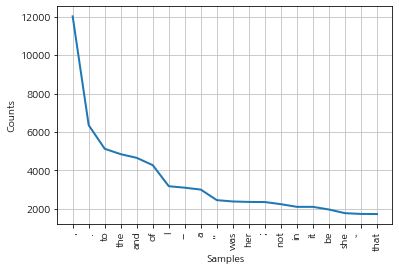

In [93]:
text.plot(20)
plt.show()

#### step3: 단어위치 그래프
dispersion_plot 에서는 단어가 사용한 위치를 시각화한다. 
소셜 형태의 각 등장인물에 대해 적용하면 다음과 같은 결과를 얻는다

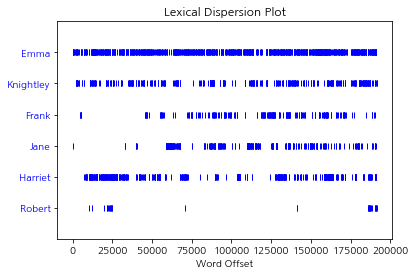

In [95]:
# 등장인물에 대해 적용 -> 어디쯤에 등장인물이 언급됐는지
# word Offset 원문의 시간순서로 200000이 뒷부분
text.dispersion_plot(["Emma", "Knightley", "Frank", "Jane", "Harriet", "Robert"])

#### step4: 단어문맥 인쇄
    concordance 메서드로 단어가 사용된 위치를 직접 표시하면 
    문맥(context)이 어떤지 볼 수 있다. 
    여기에서 문맥은 해당 단어의 앞과 뒤에 사용된 단어를 뜻한다.

In [98]:
text.concordance("Emma")
# window=1이라고 하면 앞뒤 한단어씩을 문맥으로 취급
# window=2이라고 하면 앞뒤 두단어씩을 문맥으로 취급

Displaying 25 of 855 matches:
[ Emma by Jane Austen 1816 ] VOLUME I CHAPT
ane Austen 1816 ] VOLUME I CHAPTER I Emma Woodhouse , handsome , clever , and 
both daughters , but particularly of Emma . Between _them_ it was more the int
 friend very mutually attached , and Emma doing just what she liked ; highly e
r own . The real evils , indeed , of Emma 's situation were the power of havin
ding-day of this beloved friend that Emma first sat in mournful thought of any
ing only half a mile from them ; but Emma was aware that great must be the dif
y . It was a melancholy change ; and Emma could not but sigh over it , and wis
 the rest of her life at Hartfield . Emma smiled and chatted as cheerfully as 
able to tell her how we all are . '' Emma spared no exertions to maintain this
 ' I have a great regard for you and Emma ; but when it comes to the question 
ful , troublesome creature ! '' said Emma playfully . `` That is what you have
e few people who could see faults in Emma Woodhouse , and

#### step5: 유사 단어 검색
    similar메서드는 같은 문맥에서 주어진 단어 대신 사용된 횟수가 높은 단어들을 찾는다.

In [99]:
# window를 1로줌 
text.similar("Emma", 1)

she


#### step6: 공통 문맥 인쇄
    단어의 공통 문맥을 보려면 common_contexts메서드를 사용한다.

In [103]:
# 앞쪽 윈도우1 은 but 뒤쪽 윈도우1은 was로 나옴
text.common_contexts(["Emma","she"],1)
# 1로 해주면 가장 많이 쓰인거 한세트만 보여줌
# 2로 하면 가장 많이 앞뒤문맥으로 쓰인단어와 두번째로 많이 쓰인 문맥 보여줌

but_was


### FreqDist 클래스
- FreqDist 클래스는 문서에 사용된 단어(토큰)의 사용빈도 정보를 담는 클래스이다.
- Text 클래스의 vocab 메서드로 추출할 수 있다.
- 토큰 리스트를 넣어서 직접 만들 수도 있다.
- 빈도 분석에 유용한 여러가지 메서드를 제공한다.
    - N: 빈도(횟수)
    - freq: 빈도(퍼센트)
    - most_common: 가장 많이 나오는 단어
    - plot: 가장 많이 나오는 단어 플롯

#### 실습 4: FreqDist 클래스 실습

#### step 1: Text 클래스에서 생성

In [104]:
fd=text.vocab()
type(fd)

nltk.probability.FreqDist

#### step 2: 토큰 리스트에서 생성

- 다음 코드에서는 Emma 말뭉치에서 사람의 이름(NNP)만 모아서 FreqDist 클래스 객체를 만들었다.

- 품사 태그에서 NNP(고유대명사)이면서 필요없는 단어(stop words)는 제거하였다.

In [107]:
from nltk import FreqDist
stopwords=["Mr.", "Mrs.", "Miss", "Mr", "Mrs", "Dear"]
emma_tokens = pos_tag(word_tokenize(emma_raw))
# 품사가 NNP(고유명사-이름)이고 stopwords가 아닌것만 넣어줌
names_list = [t[0] for t in emma_tokens if t[1] == "NNP" and t[0] not in stopwords]
fd_names=FreqDist(names_list)

#### step3: 단어 빈도 분석
    FreqDist 클래스는 단어를 키(key), 출현빈도률값 (value)으로 가지는 사전 자료형과 유사
    다음 코드는 전체 단어의 수, "Emma"라는 단어의 출현 횟수, 확률을 각각 계산한다

In [109]:
fd_names.N(),fd_names["Emma"], fd_names.freq("Emma")

(6924, 829, 0.11972848064702483)

most_common 메서드를 사용하면 가장 출현 횟수가 높은 단어를 찾는다.

In [111]:
fd_names.most_common(5)
# 감성분석-> 형용사를 뽑아야하는

[('Emma', 829),
 ('Harriet', 477),
 ('Weston', 429),
 ('Elton', 374),
 ('Knightley', 373)]

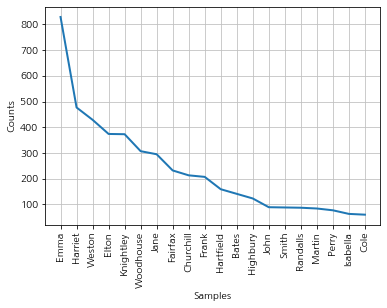

In [112]:
fd_names.plot(20)
plt.show()
# 지수함수적으로 줄어든다

### 워드클라우드
wordcloud 패키지를 사용하면 단어의 사용 빈도수에 따라 워드클라우드(Word Cloud) 시각화를 할 수 있다.

#### "엠마" 등장인물의 워드클라우드 제작

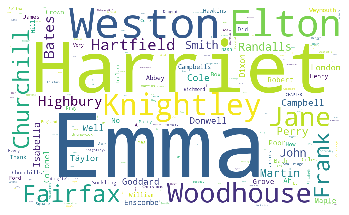

In [116]:
from wordcloud import WordCloud
wc=WordCloud(width=1000, height=600, background_color="white",random_state=0)
plt.imshow(wc.generate_from_frequencies(fd_names))
plt.axis("off")
plt.show()

### 연습문제: 소설등장인물 이름 워드클라우드 제작

구텐베르그 프로젝트의 소설 말뭉치 중 하나를 골라서 
등장인물 이름의 빈도 플롯과 워드클라우드를 제작하라

In [117]:
nltk.corpus.gutenberg.fileids()

['austen-emma.txt',
 'austen-persuasion.txt',
 'austen-sense.txt',
 'bible-kjv.txt',
 'blake-poems.txt',
 'bryant-stories.txt',
 'burgess-busterbrown.txt',
 'carroll-alice.txt',
 'chesterton-ball.txt',
 'chesterton-brown.txt',
 'chesterton-thursday.txt',
 'edgeworth-parents.txt',
 'melville-moby_dick.txt',
 'milton-paradise.txt',
 'shakespeare-caesar.txt',
 'shakespeare-hamlet.txt',
 'shakespeare-macbeth.txt',
 'whitman-leaves.txt']

In [152]:
bible_raw=nltk.corpus.gutenberg.raw("bible-kjv.txt")
text=Text(word_tokenize(bible_raw))

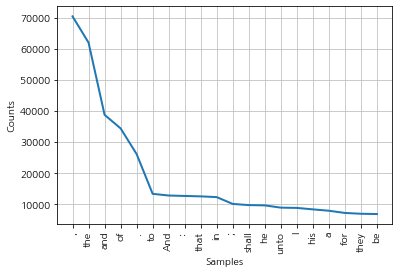

In [153]:
text.plot(20)

In [157]:
swords=["Mr.", "Mrs.", "Miss", "Mr", "Mrs", "Dear"]
# swords.append(stopwords.words("english")) swords에 불용어도 추가

In [158]:
bible_tokens = pos_tag(word_tokenize(bible_raw))
names_list = [t[0] for t in bible_tokens if t[1] == "NNP" and t[0] not in swords ]
fd_names=FreqDist(names_list)

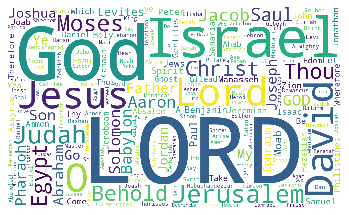

In [156]:
wc=WordCloud(width=1000, height=600, background_color="white",random_state=0)
plt.imshow(wc.generate_from_frequencies(fd_names))
plt.axis("off")
plt.show()

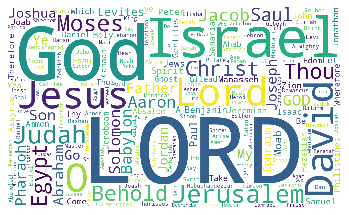

In [159]:
# 불용어 빼고 다시그린것- 왜 똑같지..
wc=WordCloud(width=1000, height=600, background_color="white",random_state=0)
plt.imshow(wc.generate_from_frequencies(fd_names))
plt.axis("off")
plt.show()

### 한글 자연어 처리
- KoNLPy

In [161]:
import konlpy

#### KoNLPy기능
- 샘플 말뭉치
    - kolaw: 헌법 말뭉치
    - kobill: 법안 말뭉치
        
- 한글 형태소 분석기(다른곳에서 만들어 놓은 패키지를 파이썬에서 쓸수있게 해놓은것)
    - KoNLPy는 다양한 형태소 분석, 태깅 라이브러리를 파이썬에서 쉽게 사용할 수 있도록
    모아놓았다.

#### 형태소 분석기

* Hannanum: 한나눔. KAIST Semantic Web Research Center 개발.
  * http://semanticweb.kaist.ac.kr/hannanum/
* Kkma: 꼬꼬마. 서울대학교 IDS(Intelligent Data Systems) 연구실 개발.
  * http://kkma.snu.ac.kr/
* Komoran: 코모란. Shineware에서 개발.
  * https://github.com/shin285/KOMORAN
* Mecab: 메카브. 일본어용 형태소 분석기를 한국어를 사용할 수 있도록 수정.
  * https://bitbucket.org/eunjeon/mecab-ko
* Open Korean Text: 오픈 소스 한국어 분석기. 과거 트위터 형태소 분석기.
  * https://github.com/open-korean-text/open-korean-text

#### 형태소 분석기 기능
각 형태소 분석기는 다음과 같은 공통 메서드를 제공
- nouns : 명사 추출
- morphs : 형태소 추출
- pos : 품사 부착

#### step1: 헌법 말뭉치

In [162]:
from konlpy.corpus import kolaw
kolaw.fileids()

['constitution.txt']

In [163]:
c=kolaw.open('constitution.txt').read()
print(c[:450])

대한민국헌법

유구한 역사와 전통에 빛나는 우리 대한국민은 3·1운동으로 건립된 대한민국임시정부의 법통과 불의에 항거한 4·19민주이념을 계승하고, 조국의 민주개혁과 평화적 통일의 사명에 입각하여 정의·인도와 동포애로써 민족의 단결을 공고히 하고, 모든 사회적 폐습과 불의를 타파하며, 자율과 조화를 바탕으로 자유민주적 기본질서를 더욱 확고히 하여 정치·경제·사회·문화의 모든 영역에 있어서 각인의 기회를 균등히 하고, 능력을 최고도로 발휘하게 하며, 자유와 권리에 따르는 책임과 의무를 완수하게 하여, 안으로는 국민생활의 균등한 향상을 기하고 밖으로는 항구적인 세계평화와 인류공영에 이바지함으로써 우리들과 우리들의 자손의 안전과 자유와 행복을 영원히 확보할 것을 다짐하면서 1948년 7월 12일에 제정되고 8차에 걸쳐 개정된 헌법을 이제 국회의 의결을 거쳐 국민투표에 의하여 개정한다.

       


#### step2: 법안 말뭉치

In [164]:
from konlpy.corpus import kobill
kobill.fileids()

['1809890.txt',
 '1809891.txt',
 '1809892.txt',
 '1809893.txt',
 '1809894.txt',
 '1809895.txt',
 '1809896.txt',
 '1809897.txt',
 '1809898.txt',
 '1809899.txt']

In [167]:
d=kobill.open('1809890.txt').read()
print(d[:400])

지방공무원법 일부개정법률안

(정의화의원 대표발의 )

 의 안
 번 호

9890

발의연월일 : 2010.  11.  12.  

발  의  자 : 정의화․이명수․김을동 

이사철․여상규․안규백

황영철․박영아․김정훈

김학송 의원(10인)

제안이유 및 주요내용

  초등학교 저학년의 경우에도 부모의 따뜻한 사랑과 보살핌이 필요

한 나이이나, 현재 공무원이 자녀를 양육하기 위하여 육아휴직을 할 

수 있는 자녀의 나이는 만 6세 이하로 되어 있어 초등학교 저학년인 

자녀를 돌보기 위해서는 해당 부모님은 일자리를 그만 두어야 하고 

이는 곧 출산의욕을 저하시키는 문제로 이어질 수 있을 것임.

  따라서 육아휴직이 가능한 자녀의 연령을 만 8세 이하로 개정하려

는 것임(안 제63조제2항제4호).



#### step3: 형태소 분석기 생성

In [170]:
from konlpy.tag import *

In [169]:
hannanum = Hannanum()
kkma=Kkma()
okt=Okt()

# 다음 형태소 분석기는 자바 등의 연결에 따라 안될 수도 있다.
komoran=Komoran()
# mecab=Mecab()

#### step4: 명사 추출
    - 문서에서 명사만 추출하려면 nouns 메서드 사용

In [171]:
# 가장 key가 되는게 명사이기 떄문에 명사 추출 중요
hannanum.nouns(c[:40])

['대한민국헌법', '유구', '역사', '전통', '빛', '우리', '대한국민', '3·1운동']

In [172]:
# 위와 다르게 대한민국헌법이 다 분리됨 -> N그램 추후 추가 설명
kkma.nouns(c[:40])

['대한',
 '대한민국',
 '대한민국헌법',
 '민국',
 '헌법',
 '유구',
 '역사',
 '전통',
 '우리',
 '국민',
 '3',
 '1',
 '1운동',
 '운동']

In [173]:
okt.nouns(c[:40])

['대한민국', '헌법', '유구', '역사', '전통', '우리', '국민', '운동']

#### step5:형태소 추출
    - 명사 뿐 아니라 모든 품사의 형태소를 알아내려면 morphs 메서드 사용

In [175]:
hannanum.morphs(c[:40])

['대한민국헌법',
 '유구',
 '하',
 'ㄴ',
 '역사',
 '와',
 '전통',
 '에',
 '빛',
 '나는',
 '우리',
 '대한국민',
 '은',
 '3·1운동',
 '으로']

In [176]:
kkma.morphs(c[:40])

['대한민국',
 '헌법',
 '유구',
 '하',
 'ㄴ',
 '역사',
 '와',
 '전통',
 '에',
 '빛나',
 '는',
 '우리',
 '대하',
 'ㄴ',
 '국민',
 '은',
 '3',
 '·',
 '1',
 '운동',
 '으로']

In [177]:
okt.morphs(c[:40])

['대한민국',
 '헌법',
 '\n\n',
 '유구',
 '한',
 '역사',
 '와',
 '전통',
 '에',
 '빛나는',
 '우리',
 '대',
 '한',
 '국민',
 '은',
 '3',
 '·',
 '1',
 '운동',
 '으로']

In [178]:
# 속도는 okt가 빠르지만 성능은 나머지 두가지가 더 나음

#### step6: 품사 부착
- pos 명령을 사용하면 품사 부착을 한다.
- 한국어 품사 태그세트로는 형태소 분석기마다 사용하는 품사 태그가 다르므로 각 형태소 분석기에 대한 문서를 참조한다.
- 부착되는 품사 태그의 기호와 의미는 tagset 속성으로 확인할 수 있다.

In [179]:
hannanum.pos(c[:40])

[('대한민국헌법', 'N'),
 ('유구', 'N'),
 ('하', 'X'),
 ('ㄴ', 'E'),
 ('역사', 'N'),
 ('와', 'J'),
 ('전통', 'N'),
 ('에', 'J'),
 ('빛', 'N'),
 ('나는', 'J'),
 ('우리', 'N'),
 ('대한국민', 'N'),
 ('은', 'J'),
 ('3·1운동', 'N'),
 ('으로', 'J')]

In [181]:
hannanum.tagset

{'E': '어미',
 'EC': '연결 어미',
 'EF': '종결 어미',
 'EP': '선어말어미',
 'ET': '전성 어미',
 'F': '외국어',
 'I': '독립언',
 'II': '감탄사',
 'J': '관계언',
 'JC': '격조사',
 'JP': '서술격 조사',
 'JX': '보조사',
 'M': '수식언',
 'MA': '부사',
 'MM': '관형사',
 'N': '체언',
 'NB': '의존명사',
 'NC': '보통명사',
 'NN': '수사',
 'NP': '대명사',
 'NQ': '고유명사',
 'P': '용언',
 'PA': '형용사',
 'PV': '동사',
 'PX': '보조 용언',
 'S': '기호',
 'X': '접사',
 'XP': '접두사',
 'XS': '접미사'}

In [182]:
kkma.pos(c[:40])

[('대한민국', 'NNG'),
 ('헌법', 'NNG'),
 ('유구', 'NNG'),
 ('하', 'XSV'),
 ('ㄴ', 'ETD'),
 ('역사', 'NNG'),
 ('와', 'JC'),
 ('전통', 'NNG'),
 ('에', 'JKM'),
 ('빛나', 'VV'),
 ('는', 'ETD'),
 ('우리', 'NNM'),
 ('대하', 'VV'),
 ('ㄴ', 'ETD'),
 ('국민', 'NNG'),
 ('은', 'JX'),
 ('3', 'NR'),
 ('·', 'SP'),
 ('1', 'NR'),
 ('운동', 'NNG'),
 ('으로', 'JKM')]

In [183]:
kkma.tagset

{'EC': '연결 어미',
 'ECD': '의존적 연결 어미',
 'ECE': '대등 연결 어미',
 'ECS': '보조적 연결 어미',
 'EF': '종결 어미',
 'EFA': '청유형 종결 어미',
 'EFI': '감탄형 종결 어미',
 'EFN': '평서형 종결 어미',
 'EFO': '명령형 종결 어미',
 'EFQ': '의문형 종결 어미',
 'EFR': '존칭형 종결 어미',
 'EP': '선어말 어미',
 'EPH': '존칭 선어말 어미',
 'EPP': '공손 선어말 어미',
 'EPT': '시제 선어말 어미',
 'ET': '전성 어미',
 'ETD': '관형형 전성 어미',
 'ETN': '명사형 전성 어미',
 'IC': '감탄사',
 'JC': '접속 조사',
 'JK': '조사',
 'JKC': '보격 조사',
 'JKG': '관형격 조사',
 'JKI': '호격 조사',
 'JKM': '부사격 조사',
 'JKO': '목적격 조사',
 'JKQ': '인용격 조사',
 'JKS': '주격 조사',
 'JX': '보조사',
 'MA': '부사',
 'MAC': '접속 부사',
 'MAG': '일반 부사',
 'MD': '관형사',
 'MDN': '수 관형사',
 'MDT': '일반 관형사',
 'NN': '명사',
 'NNB': '일반 의존 명사',
 'NNG': '보통명사',
 'NNM': '단위 의존 명사',
 'NNP': '고유명사',
 'NP': '대명사',
 'NR': '수사',
 'OH': '한자',
 'OL': '외국어',
 'ON': '숫자',
 'SE': '줄임표',
 'SF': '마침표, 물음표, 느낌표',
 'SO': '붙임표(물결,숨김,빠짐)',
 'SP': '쉼표,가운뎃점,콜론,빗금',
 'SS': '따옴표,괄호표,줄표',
 'SW': '기타기호 (논리수학기호,화폐기호)',
 'UN': '명사추정범주',
 'VA': '형용사',
 'VC': '지정사',
 'VCN': "부정 지정사, 형용사 '아니다'",
 'VC

In [184]:
okt.pos(c[:40])

[('대한민국', 'Noun'),
 ('헌법', 'Noun'),
 ('\n\n', 'Foreign'),
 ('유구', 'Noun'),
 ('한', 'Josa'),
 ('역사', 'Noun'),
 ('와', 'Josa'),
 ('전통', 'Noun'),
 ('에', 'Josa'),
 ('빛나는', 'Verb'),
 ('우리', 'Noun'),
 ('대', 'Modifier'),
 ('한', 'Modifier'),
 ('국민', 'Noun'),
 ('은', 'Josa'),
 ('3', 'Number'),
 ('·', 'Punctuation'),
 ('1', 'Number'),
 ('운동', 'Noun'),
 ('으로', 'Josa')]

In [185]:
okt.tagset

{'Adjective': '형용사',
 'Adverb': '부사',
 'Alpha': '알파벳',
 'Conjunction': '접속사',
 'Determiner': '관형사',
 'Eomi': '어미',
 'Exclamation': '감탄사',
 'Foreign': '외국어, 한자 및 기타기호',
 'Hashtag': '트위터 해쉬태그',
 'Josa': '조사',
 'KoreanParticle': '(ex: ㅋㅋ)',
 'Noun': '명사',
 'Number': '숫자',
 'PreEomi': '선어말어미',
 'Punctuation': '구두점',
 'ScreenName': '트위터 아이디',
 'Suffix': '접미사',
 'Unknown': '미등록어',
 'Verb': '동사'}

In [187]:
tagsets = pd.DataFrame()
N = 67
tagsets["Hannanum-기호"] = list(hannanum.tagset.keys()) + list("*" * (N - len(hannanum.tagset)))
tagsets["Hannanum-품사"] = list(hannanum.tagset.values()) + list("*" * (N - len(hannanum.tagset)))
tagsets["Kkma-기호"] = list(kkma.tagset.keys()) + list("*" * (N - len(kkma.tagset)))
tagsets["Kkma-품사"] = list(kkma.tagset.values()) + list("*" * (N - len(kkma.tagset)))
tagsets["Komoran-기호"] = list(komoran.tagset.keys()) + list("*" * (N - len(komoran.tagset)))
tagsets["Komoran-품사"] = list(komoran.tagset.values()) + list("*" * (N - len(komoran.tagset)))
tagsets["OKT-기호"] = list(okt.tagset.keys()) + list("*" * (N - len(okt.tagset)))
tagsets["OKT-품사"] = list(okt.tagset.values()) + list("*" * (N - len(okt.tagset)))
tagsets

,Hannanum-기호,Hannanum-품사,Kkma-기호,Kkma-품사,Komoran-기호,Komoran-품사,OKT-기호,OKT-품사
0,E,어미,EC,연결 어미,EC,연결 어미,Adjective,형용사
1,EC,연결 어미,ECD,의존적 연결 어미,EF,종결 어미,Adverb,부사
2,EF,종결 어미,ECE,대등 연결 어미,EP,선어말어미,Alpha,알파벳
3,EP,선어말어미,ECS,보조적 연결 어미,ETM,관형형 전성 어미,Conjunction,접속사
4,ET,전성 어미,EF,종결 어미,ETN,명사형 전성 어미,Determiner,관형사
...,...,...,...,...,...,...,...,...
62,*,*,XPV,용언 접두사,*,*,*,*
63,*,*,XR,어근,*,*,*,*
64,*,*,XSA,형용사 파생 접미사,*,*,*,*
65,*,*,XSN,명사파생 접미사,*,*,*,*


#### step7: 빈도 분석
    - NLTK의 기능을 사용하여 한극 빈도 분석 가능

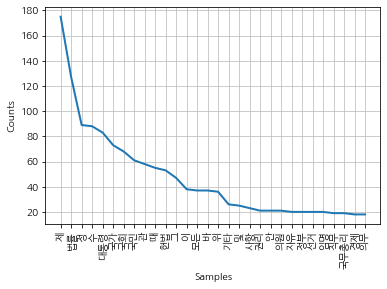

In [189]:
from nltk import Text

kolaw = Text(okt.nouns(c), name="kolaw")
kolaw.plot(30)
plt.show()

#### step 8: 한글 워드클라우드

In [190]:
from wordcloud import WordCloud

# 자신의 컴퓨터 환경에 맞는 한글 ttf 폰트 경로를 설정
font_path = 'C:/Windows/Fonts/NanumGothic.ttf'
# 윈도우의 경우는 다음 경로 사용
# font_path = 'C:/Windows/Fonts/malgun.ttf'

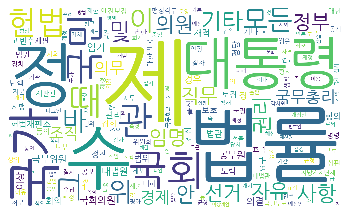

In [191]:
wc = WordCloud(width = 1000, height = 600, background_color="white", font_path=font_path)
plt.imshow(wc.generate_from_frequencies(kolaw.vocab()))
plt.axis("off")
plt.show()

### KoNLPy 사용자 사전추가
교재에 빠진듯 아래 링크에 자료있음
https://datascienceschool.net/view-notebook/4bfa8007982d4c7ba35d8b42cecd38c9/

#### Hannanum 사용자 사전 추가

In [192]:
sentence = '자유한국당, "박근혜-최순실 국정농단 태블릿 PC는 거짓"이라고 주장'

In [196]:
from konlpy.tag import Hannanum

In [197]:
hannanum = Hannanum()
hannanum.pos(sentence)

[('자유한국당,', 'N'),
 ('"박근혜-최순실', 'N'),
 ('국정농단', 'N'),
 ('태블릿', 'N'),
 ('PC', 'F'),
 ('는', 'J'),
 ('거짓', 'N'),
 ('"', 'S'),
 ('이', 'J'),
 ('라', 'E'),
 ('고', 'J'),
 ('주장', 'N')]

In [200]:
dic_user = "C:/Users/shs40/anaconda3/Lib/site-packages/konlpy/java/data/kE/dic_user.txt"
!tail {dic_user}

洹몃텇�뱾	npp
洹뱀쭊	ncps
�떦�떊�뱾	npp
�룞�웾�옱	ncn
�꽌異⑹썝	ncn
�슦泥댄넻	ncn
�쓽誘�	ncpa
�씠�떊紐�	nqpc
�옄�룞�궗	ncn
쨌	sy


### Scikit-Learn의 문서 전처리 기능

#### Dictvectorizer

In [201]:
from sklearn.feature_extraction import DictVectorizer
v = DictVectorizer(sparse=False)
D = [{'A': 1, 'B': 2}, {'B': 3, 'C': 1}]
X = v.fit_transform(D)
X

array([[1., 2., 0.],
       [0., 3., 1.]])

In [203]:
v.feature_names_

['A', 'B', 'C']

In [204]:
v.transform({'C': 4, 'D': 3})
# D는 없는걸로 처리가됨 처음 생성시 정의되지 않았으니까

array([[0., 0., 4.]])

#### CountVectorizer
DIctvectorizer는 count를 해서 넣어줘야했는데
CountVectorizer는 다음과 같은 세가지 작업을 수행한다.

- 문서를 토큰 리스트로 변환한다.
- 각 문서에서 토큰의 출현 빈도를 센다.
- 각 문서를 BOW 인코딩 벡터로 변환한다.

In [205]:
from sklearn.feature_extraction.text import CountVectorizer
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
    'The last document?',
]
vect = CountVectorizer()
vect.fit(corpus)
vect.vocabulary_
# this 는9번째 단어라는뜻 인덱스를 보여줌

{'this': 9,
 'is': 3,
 'the': 7,
 'first': 2,
 'document': 1,
 'second': 6,
 'and': 0,
 'third': 8,
 'one': 5,
 'last': 4}

In [209]:
vect.transform(['This is the second document.']).toarray()
# 위에서 0번째인 and는 안나왔고 1번째인 document는 한번나왔고...이런식으로 

array([[0, 1, 0, 1, 0, 0, 1, 1, 0, 1]], dtype=int64)

In [211]:
vect.transform(['Something completely new.']).toarray()
# 포함된 단어가 하나도 없다

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int64)

In [212]:
vect.transform(corpus).toarray()

array([[0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 1],
       [0, 1, 0, 0, 1, 0, 0, 1, 0, 0]], dtype=int64)

### Stop Words

In [213]:
vect = CountVectorizer(stop_words=["and", "is", "the", "this"]).fit(corpus)
vect.vocabulary_

{'first': 1, 'document': 0, 'second': 4, 'third': 5, 'one': 3, 'last': 2}

In [214]:
# 불용어 모음집을 사용하여 빼고 남은단어들
vect = CountVectorizer(stop_words="english").fit(corpus)
vect.vocabulary_

{'document': 0, 'second': 1}

### 토큰

In [215]:
vect = CountVectorizer(analyzer="char").fit(corpus)
vect.vocabulary_

{'t': 16,
 'h': 8,
 'i': 9,
 's': 15,
 ' ': 0,
 'e': 6,
 'f': 7,
 'r': 14,
 'd': 5,
 'o': 13,
 'c': 4,
 'u': 17,
 'm': 11,
 'n': 12,
 '.': 1,
 'a': 3,
 '?': 2,
 'l': 10}

In [216]:
vect = CountVectorizer(token_pattern="t\w+").fit(corpus)
vect.vocabulary_

{'this': 2, 'the': 0, 'third': 1}

In [217]:
import nltk

vect = CountVectorizer(tokenizer=nltk.word_tokenize).fit(corpus)
vect.vocabulary_

{'this': 11,
 'is': 5,
 'the': 9,
 'first': 4,
 'document': 3,
 '.': 0,
 'second': 8,
 'and': 2,
 'third': 10,
 'one': 7,
 '?': 1,
 'last': 6}

### N-그램

N그램은 단어장 생성에 사용할 토큰의 크기를 결정한다. 모노그램(monogram)은 토큰 하나만 단어로 사용하며 
바이그램(bigram)은 두 개의 연결된 토큰을 하나의 단어로 사용한다.

In [219]:
vect = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
vect.vocabulary_

{'this is': 12,
 'is the': 2,
 'the first': 7,
 'first document': 1,
 'the second': 9,
 'second second': 6,
 'second document': 5,
 'and the': 0,
 'the third': 10,
 'third one': 11,
 'is this': 3,
 'this the': 13,
 'the last': 8,
 'last document': 4}

In [221]:
# t\w+ -> t로 시작하는 것들중 /1,2 -> 모노와 바이그램 둘다
vect = CountVectorizer(ngram_range=(1, 2), token_pattern="t\w+").fit(corpus)
vect.vocabulary_

{'this': 3, 'the': 0, 'this the': 4, 'third': 2, 'the third': 1}

### 빈도수
max_df, min_df 인수를 사용하여 문서에서 토큰이 나타난 횟수를 기준으로 단어장을 구성할 수도 있다. 
토큰의 빈도가 max_df로 지정한 값을 초과 하거나 min_df로 지정한 값보다 작은 경우에는 무시한다. 
인수 값은 정수인 경우 횟수, 부동소수점인 경우 비중을 뜻한다.